This notebook goes through how to create a **repeating pattern** of objects.

# IMPORTS

In [1]:
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from spomso.cores.helper_functions import generate_grid, smarter_reshape, hard_binarization
from spomso.cores.geom_3d import Box

# PARAMETERS

In [2]:
# size of the volume
co_size = 3, 3, 3
# resolution of the volume
co_resolution = 100, 100, 100

show = "FIELD" # BINARY, FIELD
show_midplane = True
show_3d = False

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a numpy.ndarray with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

**SPOMSO** includes different types of modifications which repeat the geometry in space. Currently the implemented types are **INFINITE**, **FINITE**, and **FINITE_RESCALED**.

In [4]:
# INFINITE, FINITE, FINITE_RESCALED
repetition_type = "INFINITE"

Create the **box** by the defining the side lengths to be **1**, **0.5**, and **0.25**:

In [5]:
box = Box(1.0, 0.5, 0.25)

**INFINITE** repetion repeats the geometry along all axes infinetly many times and the only parameter are the distances between (the centers of) the instances along each axis. In this case the instances are separated by **1.2, 1, 0.5** along the x, y, and z-axis:

In [6]:
if repetition_type=="INFINITE":
    box.infinite_repetition((1.2, 1, 0.5))

The **FINITE** repetition repeats the geometry a finite number of times within a certain bounding box. In this case the bounding box of the finite repetition is **(2.0, 3.0, 2.0)** [first parameter] and there are **2**, **3**, and **4** repetition along the x, y and z-axis, respectively [second parameter]:

In [7]:
if repetition_type=="FINITE":
    box.finite_repetition((2., 3., 2.), (2, 3, 4))

Since the dimensions of the box are **(1, 0.5, 0.25)**, the size of the bounding box is **(2., 3., 2.)**, and since there are **2** repetitions along the x-axis, the instances along the x-axis will be merged. Therefore, wider boxes are created.

The **finite repetition** does not rescale the instances, only positions the centers of instances on a *cubic* grid. The distances between instances aequal to *bounding_box_size/number_of_repetitions* along each axis.

The **FINITE_RESCALED** repetition rescales the instances so they best fit into the bounding box.

The bounding box of the finite repetition is **(2.0, 3.0, 2.0)** [first parameter].There are **2**, **3**, and **5** repetition along the x, y and z-axis, respectively [second parameter].
The size of (the bounding box) of each instance, and the padding along each axis must be provided, in this case the size of the bounding box is **1**, **0.5**, and **1** [third parameter], and the **padding** is set to be **0.2**, **0.3**, and **0.1** [fourth parameter].

The instances are rescaled so that they are as large as possible while still satisfying the padding constraints. The proportions of the instances are the same as the proportions of the original geometry.

In [8]:
if repetition_type=="FINITE_RESCALED":
    box.finite_repetition_rescaled((2., 3., 2.), (2, 3, 5), (1, 0.5, 0.25), (0.2, 0.3, 0.1))

## EVALUATE

Evaluate the SDF of the **box** to create a signed distance field 3D map. This is done by calling the **create** method and passing in the point cloud of coordinates:

In [9]:
box_pattern = box.create(coor)

# BINARIZATION

Convert the distance field to a binary voxel map, where 1 corresponds to the interior and 0 to the exterior of the geometry.

In [10]:
if show_midplane:
    field = smarter_reshape(box_pattern, co_resolution)
    if show=="BINARY":
        pattern_2d = hard_binarization(field, 0)

if show=="BINARY":
    pattern = hard_binarization(box_pattern, 0)

# PLOT

Drawing results...


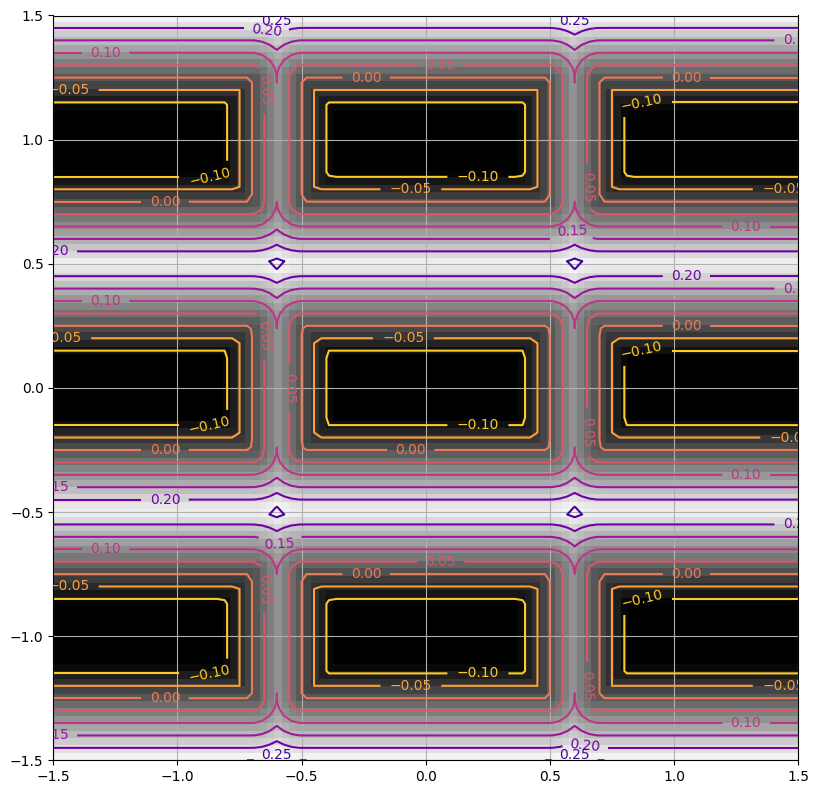

In [11]:
print("Drawing results...")
# Mid-plane cross-section plot
if show_midplane and show=="BINARY":
    fig, ax = plt.subplots(1,1, figsize=(8.25, 8.25))
    ax.imshow(pattern_2d[:, :, co_resolution[2]//2].T,
              cmap="binary_r",
              extent=(-co_size[0]/2, co_size[0]/2,
                      -co_size[1]/2, co_size[1]/2),
              origin="lower"
              )
    ax.grid()

    fig.tight_layout()
    plt.show()

if show_midplane and show == "FIELD":
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    ax.imshow(field[:, :, co_resolution[2]//2].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    z_mask = coor[2] == 0
    cs = ax.contour(coor[0, z_mask].reshape(co_res_new[0], co_res_new[1]),
                    coor[1, z_mask].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :, co_resolution[2]//2],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()

    fig.tight_layout()
    plt.show()

In [12]:
# Isosurfaces plot
if show_3d and show=="BINARY":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=pattern,
        isomin=0.1,
        isomax=1,
        opacity=0.1,
        surface_count=2,
    ))
    fig.show()

if show_3d and show=="FIELD":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=box_pattern,
        isomin=-0,
        isomax=0.5,
        opacity=0.1,
        surface_count=5,
    ))
    fig.show()